<a href="https://colab.research.google.com/github/a24lorie/DeepLearningKeras/blob/UIMP/TrabajoFinal_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final: Deteccion porcentaje de alimentos en imagenes

### 1. Liberias
Caraga de las librerias necesarias "**Keras**", "**TensorFlow**", "**Scikit-learn**" (Machine learning in Python), etc.

In [0]:
import pandas as pd
import numpy as np  # linear algebra

from google.colab import drive
from sklearn.model_selection import train_test_split

import tensorflow as tf
import datetime

from keras import applications
from keras import optimizers
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as kerasBack 

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model 
from keras.layers import Conv2D, Activation, BatchNormalization 
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Dense, Flatten

from matplotlib import pyplot

### 2. Preparar datos de entrenamiento
Para el trabajo se utilizará el conjunto de imágenes facilitado en el enunciado del ejercicio UNIMIB2016 Food Database1, con un total de **1027 imágenes** de alimentos, con una dimensión de **640 × 480** píxeles en RGB. 

El fichero **DL_UNIMIB2016.zip** se cargará de una ruta el Google Drive y contiene un directorio **imagenes** con el contenido del dataset y un fichero **percentages.csv** con dos columnas ["**image_name**", "**food_pixels**"] con le porcentaje correspondientes a cada imagen. 

La calidad de los modelos se estimará utilizando el error cuadrático medio (MSE) o la raíz del error cuadrático medio (RMSE). En concreto, cada alumno deberá de proponer e implementar tres aproximaciones que comparará con un baseline cuyo RMSE = 4.8

In [0]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)

# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/MasterIA-UIMP/SegundoAño/DeepLearning/TrabajoFinal/Datos/DL_UNIMIB2016.zip' >> /dev/null
!rm -rf ./logs/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def root_mean_squared_error(y_true, y_pred):
  return kerasBack.sqrt(kerasBack.mean(kerasBack.square(y_pred - y_true))) 

def plot_history(history):
  %matplotlib inline
  %config InlineBackend.figure_format = 'retina'
  
  pyplot.figure()
  pyplot.xlabel('Epoch')
  pyplot.ylabel('RMSE')
  pyplot.plot(history.epoch, np.array(history.history['loss']),label='Error (loss) en entrenamiento')
  pyplot.plot(history.epoch, np.array(history.history["val_loss"]), label="Error (Valid loss) en validacion")
  pyplot.legend()   

import time
def timing():
    start_time = time.time()
    return lambda x: print("{} [{:.2f}s]".format(x, time.time() - start_time))

In [0]:
# Especificamos los paths al directorio que contiene las imagenes y al fichero con los porcentajes
data_path = 'UNIMIB2016/'
imgs_path = data_path + "images/"
labels_path = data_path + "percentage.csv"

# Leemos el fichero CSV con las etiquetas
labels = pd.read_csv(labels_path , dtype = {"food_pixels": "float64"})

# Creamos las tres particiones de datos: entrenamiento(70%), validación(15%) y test(15%)
seed = 34014

# Primero se divide el conjunto labels en dos conjuntos train_data(70%) y test_data (30%)
train_data, other = train_test_split(labels, test_size=0.3, random_state=seed) 
# Luego se divide el conjunto test_dataobteniendose finalmente dos conjuntos dev_data(15%) y test_data (15%)
val_data, test_data = train_test_split(other, test_size=0.5, random_state=seed) 

# Actualizamos los indices de cada particion
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Preparamos los datos utilizando Data Augmentation con normalización (rescale y horizontal flip)
datagen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True)

# Especificamos una serie de parámetros dependientes del conjunto de datos
# dimensiones de la imagen
img_width = 640
img_height = 480
# nombres de las columnas en el fichero CSV  
x_col = 'image_name'          
y_col = 'food_pixels'

# Generamos los batches con los datos para las tres particiones
batch_size = 64
train_generator = datagen.flow_from_dataframe(dataframe=train_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                            class_mode="other", target_size=(img_width,img_height), batch_size=batch_size )
val_generator = datagen.flow_from_dataframe(dataframe=val_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                            class_mode="other", target_size=(img_width,img_height), batch_size=batch_size )
test_generator = datagen.flow_from_dataframe(dataframe=test_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                           class_mode="other", target_size=(img_width,img_height), batch_size=batch_size )


Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.


## 3.1 Ad-Hoc CNN


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 640, 480, 15)      195       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 320, 240, 15)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 320, 240, 15)      915       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 160, 120, 15)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 160, 120, 15)      915       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 80, 60, 15)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 72000)            

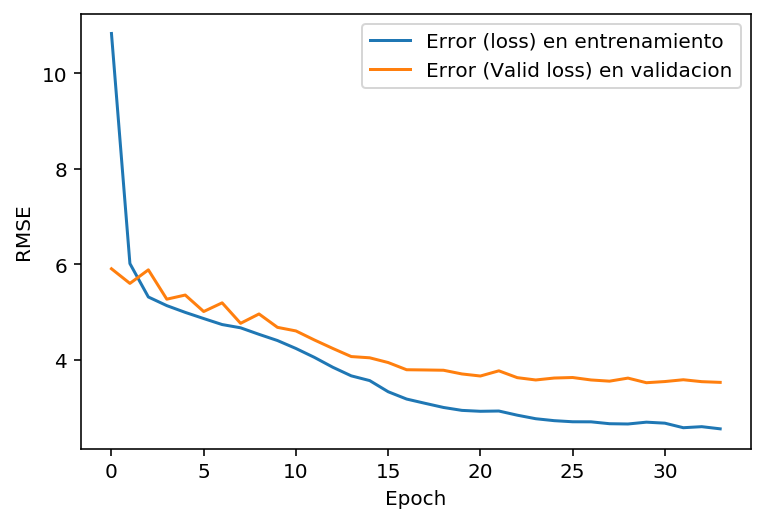

In [0]:

# Se crea el modelo utilizando el API secuential
customBuild_model=Sequential()

# Se añade una primera capa convolucional con 15 filtros y un tamaño 2x2 con funcion de activacion relu seguida por una capa maxPooling de tamaño 2x2
customBuild_model.add(Conv2D(filters=15,kernel_size=2,padding="same",activation="relu",input_shape=(img_width,img_height,3)))
customBuild_model.add(MaxPooling2D(pool_size=2, padding="same", strides=(2,2)))

# Se añade una segunda capa convolucional con 8 filtros y un tamaño 2x2 con funcion de activacion relu seguida por una capa averagePooling de tamaño 2x2
customBuild_model.add(Conv2D(filters=15,kernel_size=2,padding="same",activation="relu"))
customBuild_model.add(AveragePooling2D(pool_size=2, padding="same", strides=(2,2)))

# Se añade una tercera capa convolucional con 6 filtros y un tamaño 2x2 con funcion de activacion relu seguida por una capa maxPooling de tamaño 2x2
customBuild_model.add(Conv2D(filters=15,kernel_size=2,padding="same",activation="relu"))
customBuild_model.add(AveragePooling2D(pool_size=2, padding="same", strides=(2,2)))

# Capa flatten para convertir la salida de caracteristicas a un vector unidimensional donde se conectaran las capas de clasficacion
customBuild_model.add(Flatten())

# Se añade una capa completamente conectada con 16 neuronas, funcion de activacion relu y regularizador l2 con ratio 0.01
customBuild_model.add(Dense(16,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
# Se añade una capa completamente conectada con 12 neuronas, funcion de activacion relu y regularizador l2 con ratio 0.01
customBuild_model.add(Dense(12,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
# Se añade la capa final con una neurona y funcion de activacion relu 
customBuild_model.add(Dense(1, activation='relu'))

# Creamos el modelo final y lo compilamos
customBuild_model.compile(loss=root_mean_squared_error,  # función de pérdida RMSE para problemas de regresion
                          optimizer=Adam(lr=1e-4),       # optimizador Adam, learning rate (lr)
                          metrics=[root_mean_squared_error])

# Se crean las opciones de EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode="min")
model_check = ModelCheckpoint('best_adhoc.h5', monitor='val_loss', mode='min', save_best_only=True)
callbacks_list = [early_stopping, model_check]

 # representación en modo texto del modelo
customBuild_model.summary() 

t = timing()
history_customModel = customBuild_model.fit_generator(
                                      train_generator,
                                      epochs=50,  # numero de epochs
                                      verbose=2,  # muestra informacion del error al finalizar cada epoch
                                      steps_per_epoch=len(train_data)/batch_size,
                                      validation_data=val_generator,
                                      validation_steps=len(val_data)/batch_size,
                                      callbacks=callbacks_list) # opciones de configuracion de EarlyStopping
# callbacks=[tf.keras.callbacks.TensorBoard('logs/model_customV1', histogram_freq=1)])
t("Training time for Ad-Hoc Model")


# Se carga el mejor modelo obtenido con el proceso de EarlyStopping dado que el valor del parametro patiente es 3 
customBuild_model_saved = load_model('best_adhoc.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# Por ultimo, podemos evaluar el modelo en el conjunto de test
print()
test_loss_custom, test_acc_custom = customBuild_model_saved.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_acc: %.4f" % (test_loss_custom, test_acc_custom))  


plot_history(history_customModel)

## 3.2 DenseNet121
Una alternativa a crear una CNN y entrenarla desde cero, es utilizar modelos pre-entrenados con grandes conjuntos de datos. En esta práctica se utiliza el modelo DenseNet121 pre-entrenado con Keras.

Al modelo base se le añaden unas capas finales que nos permitan resolver nuestro problema de regresión. Los parámetros de estas nuevas capas se aprenderán durante el proceso de entrenamiento, mientras que el resto de pesos del modelo permacerán fijos (es decir, los pesos del resto de capas serán los correspondientes al modelo base entrenado con ImageNet)



29089792/29084464 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 640, 480, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 646, 486, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 320, 240, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 320, 240, 64) 256         conv1/conv[0][0]                 
_________________________

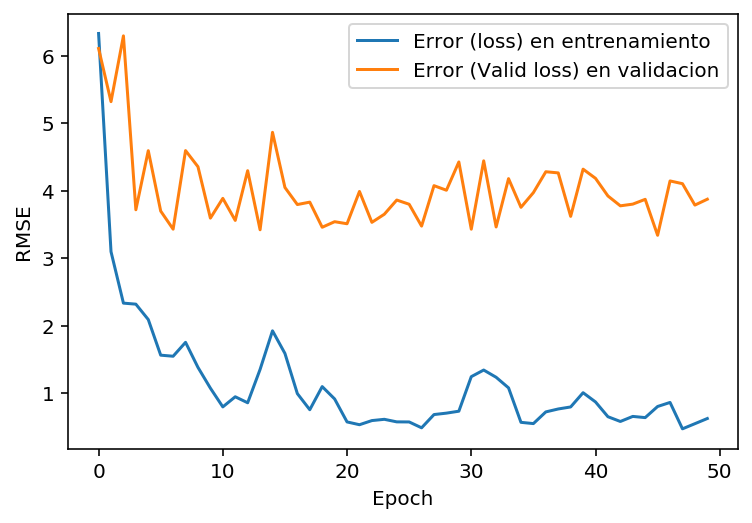

In [0]:
# transferLearning_V1 = applications.xception.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# transferLearning_V1 = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
# Cargamos el modelo DenseNet121 pre-entrenado con ImageNet sin añadir las capas de clasificacion (top)
transferLearning_V1 = applications.densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

# Se fijan las capas de extraccion de caracteristicas para que no se actualicen durante el entrenamiento 
for layer in transferLearning_V1.layers:
    layer.trainable = False

 # Añadimos nuevas capas de clasificacion al final para adaptar el modelo a nuestro problema 
x = transferLearning_V1.output
x = AveragePooling2D(pool_size=2, padding="same", strides=(2,2))(x)
# Capa flatten para convertir la salida de caracteristicas a un vector unidimensional donde se conectaran las capas de clasficacion
x = Flatten()(x)
# Se añade una capa completamente conectada con 256 neuronas, funcion de activacion relu
x = Dense(256, activation='relu')(x)
# Se añade una segunda capa completamente conectada con 256 neuronas, funcion de activacion relu
x = Dense(256, activation='relu')(x)
# Añadimos una última capa completamente conectada con 1 neurona para obtener la salida de la red
finalLayer_v1 = Dense(1, activation='relu')(x)

# Creamos el modelo final y lo compilamos
model_customV1 = Model(inputs=[transferLearning_V1.input], outputs=[finalLayer_v1])
model_customV1.compile(loss=root_mean_squared_error,
                    optimizer=Adam(lr=1e-4), 
                    metrics=[root_mean_squared_error])

 # representación en modo texto del modelo
model_customV1.summary() 

t = timing()
history_modelV1 = model_customV1.fit_generator(
                                      train_generator,
                                      epochs=50,  # numero de epochs
                                      verbose=2,  # muestra informacion del error al finalizar cada epoch
                                      steps_per_epoch=len(train_data)/batch_size,
                                      validation_data=val_generator,
                                      validation_steps=len(val_data)/batch_size)
t("Training time for Custom Model V1")

# Por ultimo, podemos evaluar el modelo en el conjunto de test
print()
test_loss_v1, test_acc_v1 = model_customV1.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_acc: %.4f" % (test_loss_v1, test_acc_v1))  


plot_history(history_modelV1)

## 3.3 DenseNet121 v2 - Overfitting 

Dropout and Regularization

Para evitar el sobreajuste el modelo anterior 

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 640, 480, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 646, 486, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 320, 240, 64) 9408        zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 320, 240, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

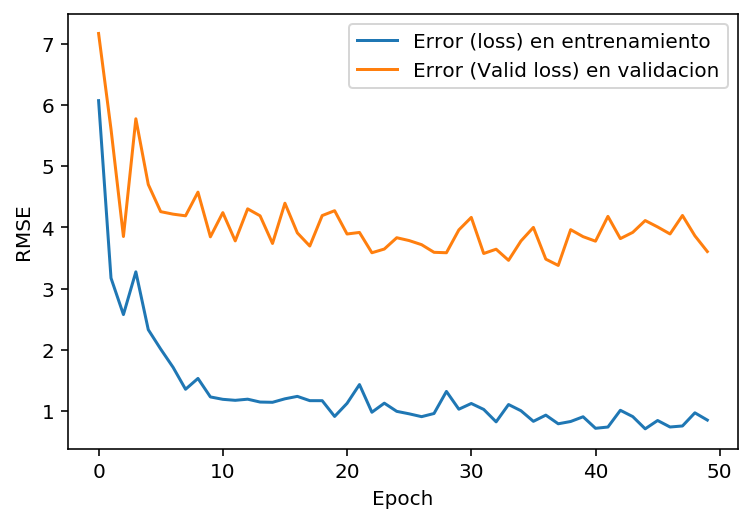

In [0]:
# transferLearning_V2 = applications.xception.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# transferLearning_V2 = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
# Cargamos el modelo DenseNet121 pre-entrenado con ImageNet sin añadir las capas de clasificacion (top)
transferLearning_V2 = applications.densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

# Se fijan las capas de extraccion de caracteristicas para que no se actualicen durante el entrenamiento 
for layer in transferLearning_V2.layers:
    layer.trainable = False

# Añadimos nuevas capas de clasificacion al final para adaptar el modelo a nuestro problema 
x = transferLearning_V2.output
x = AveragePooling2D(pool_size=2, padding="same", strides=(2,2))(x) 
# Capa flatten para convertir la salida de caracteristicas a un vector unidimensional donde se conectaran las capas de clasficacion
x = Flatten()(x)
# Se añade una capa completamente conectada con 256 neuronas, funcion de activacion relu y regularizador l2 con ratio 0.001
x = Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu')(x)
# Se añade una capa de dropout donde se descarta el 1% de las conexiones con la siguiente capa
x = Dropout(0.01)(x)
# Se añade una segunda capa completamente conectada con 256 neuronas, funcion de activacion relu y regularizador l2 con ratio 0.0001
x = Dense(256, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
# Añadimos una última capa completamente conectada con 1 neurona para obtener la salida de la red
finalLayer_v2 = Dense(1, activation='relu')(x)

# Creamos el modelo final y lo compilamos
model_customV2 = Model(inputs=[transferLearning_V2.input], outputs=[finalLayer_v2])
model_customV2.compile(loss=root_mean_squared_error,
                    optimizer=Adam(lr=1e-4), 
                    metrics=[root_mean_squared_error])

# representación en modo texto del modelo
model_customV2.summary() 

t = timing()
history_modelV2 = model_customV2.fit_generator(
                                      train_generator,
                                      epochs=50,  # numero de epochs
                                      verbose=2,  # muestra informacion del error al finalizar cada epoch
                                      steps_per_epoch=len(train_data)/batch_size,
                                      validation_data=val_generator,
                                      validation_steps=len(val_data)/batch_size)
t("Training time for Custom Model V2")

# Por ultimo, podemos evaluar el modelo en el conjunto de test
print()
test_loss_v2, test_acc_v2 = model_customV2.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_acc: %.4f" % (test_loss_v2, test_acc_v2))  


plot_history(history_modelV2) 

## 3.4 DenseNet121 v3 - Early Stopping 
Dropout, Regularization and Early Stopping

https://www.kaggle.com/sid321axn/regularization-techniques-in-deep-learning

https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/

https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 640, 480, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, 646, 486, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 320, 240, 64) 9408        zero_padding2d_17[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 320, 240, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

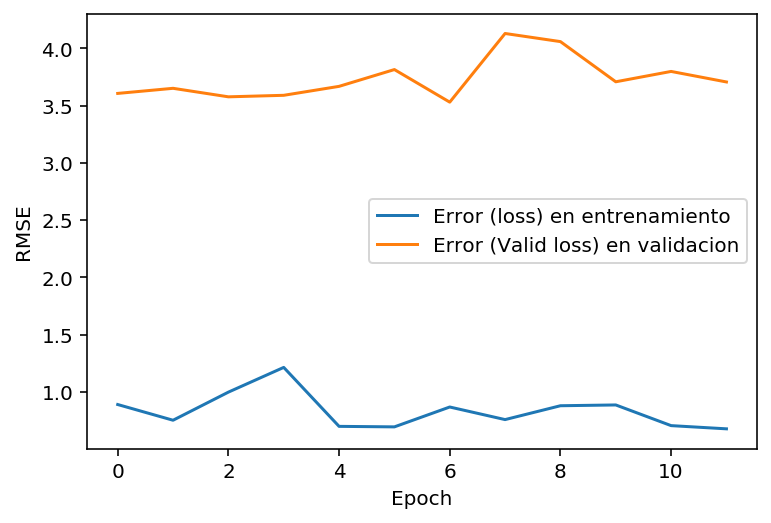

In [0]:
# transferLearning_V4 = applications.xception.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# transferLearning_V4 = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
# Cargamos el modelo DenseNet121 pre-entrenado con ImageNet sin añadir las capas de clasificacion (top)
transferLearning_V4 = applications.densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

# Se fijan las capas de extraccion de caracteristicas para que no se actualicen durante el entrenamiento 
for layer in transferLearning_V4.layers:
     layer.trainable = False

# Añadimos nuevas capas de clasificacion al final para adaptar el modelo a nuestro problema       
x = transferLearning_V4.output

x = AveragePooling2D(pool_size=2, padding="same", strides=(2,2))(x) 
# Capa flatten para convertir la salida de caracteristicas a un vector unidimensional donde se conectaran las capas de clasficacion
x = Flatten()(x)
# Se añade una capa completamente conectada con 256 neuronas, funcion de activacion relu y regularizador l2 con ratio 0.001
x = Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu')(x)
# Se añade una capa de dropout donde se descarta el 1% de las conexiones con la siguiente capa
x = Dropout(0.01)(x)
# Se añade una segunda capa completamente conectada con 256 neuronas, funcion de activacion relu y regularizador l2 con ratio 0.0001
x = Dense(256, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
# Añadimos una última capa completamente conectada con 1 neurona para obtener la salida de la red
finalLayer_v4 = Dense(1, activation='relu')(x)

# Creamos el modelo final y lo compilamos
model_customV4 = Model(inputs=[transferLearning_V4.input], outputs=[finalLayer_v4])
model_customV4.compile(loss=root_mean_squared_error,
                    optimizer=Adam(lr=1e-4), 
                    metrics=[root_mean_squared_error])

# representación en modo texto del modelo
model_customV4.summary() 

# Se crean las opciones de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)
model_check = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
callbacks_list = [early_stopping, model_check]

t = timing()
history_modelV4 = model_customV2.fit_generator(
                                      train_generator,
                                      epochs=50,  # numero de epochs
                                      verbose=2,  # muestra informacion del error al finalizar cada epoch
                                      steps_per_epoch=len(train_data)/batch_size,
                                      validation_data=val_generator,
                                      validation_steps=len(val_data)/batch_size,
                                      callbacks=callbacks_list) # opciones de configuracion de EarlyStopping
t("Training time for Custom Model V4")


# Se carga el mejor modelo obtenido con el proceso de EarlyStopping dado que el valor del parametro patiente es 3 
saved_model = load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# Por ultimo, podemos evaluar el modelo en el conjunto de test
print()
test_loss_v4, test_acc_v4 = saved_model.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_acc: %.4f" % (test_loss_v4, test_acc_v4))  

plot_history(history_modelV4) 

## 3.5 DenseNet121 v4 - Fine Tuning


In [0]:
# transferLearning_V5 = applications.xception.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# transferLearning_V5 = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
# Cargamos el modelo DenseNet121 pre-entrenado con ImageNet sin añadir las capas de clasificacion (top)
transferLearning_V5 = applications.densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

# Inicialmente para poder seleccionar que capas de seleccion de caracteristicas reentrenar se fijan todas las capas de 
# extraccion de caracteristicas
for layer in transferLearning_V5.layers:
    layer.trainable = False
        
# Dado que las capas de extraccion de caracterisiticas ya se han entrenado se activan las ultimas 128 capas (dos ultimos bloques 
# de la arquitectura DenseNet con las caracterisiticas especificas) para reajustarlas con el nuevo set de datos
for layer in transferLearning_V5.layers[len(transferLearning_V5.layers)-128:]:
  # for layer in transferLearning_V5.layers:
	layer.trainable = True
 
# Se imprime el estado de todas las capas para verificar cuales son entrenables y cuales nos
for layer in transferLearning_V5.layers:
	print("{}: {}".format(layer, layer.trainable))
 
# Añadimos nuevas capas de clasificacion al final para adaptar el modelo a nuestro problema 
x = transferLearning_V5.output


x = AveragePooling2D(pool_size=2, padding="same", strides=(2,2))(x) 
# Capa flatten para convertir la salida de caracteristicas a un vector unidimensional donde se conectaran las capas de clasficacion
x = Flatten()(x)
# Se añade una capa completamente conectada con 256 neuronas, funcion de activacion relu y regularizador l2 con ratio 0.001
x = Dense(256, kernel_regularizer=regularizers.l2(0.005), activation='relu')(x)
# Se añade una capa de dropout donde se descarta el 5% de las conexiones con la siguiente capa
x = Dropout(0.05)(x)
# Se añade una segunda capa completamente conectada con 256 neuronas, funcion de activacion relu y regularizador l2 con ratio 0.0001
x = Dense(256, kernel_regularizer=regularizers.l2(0.005), activation='relu')(x)
# Añadimos una última capa completamente conectada con 1 neurona para obtener la salida de la red
finalLayer_v5 = Dense(1, activation='relu')(x)

# Creamos el modelo final y lo compilamos con un valor de learning rate mas pequeño debido a que estamos realizando un fine-tuning de 
# la red y no nos interesa descartar el valor de los pesos ya entrenados.
model_customV5 = Model(inputs=[transferLearning_V5.input], outputs=[finalLayer_v5])
model_customV5.compile(loss=root_mean_squared_error,
                    optimizer=Adam(lr=1e-5), 
                    metrics=[root_mean_squared_error])

# representación en modo texto del modelo
model_customV5.summary() 


<keras.engine.input_layer.InputLayer object at 0x7f7f3109c358>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7f3109c7f0>: False
<keras.layers.convolutional.Conv2D object at 0x7f7f3109c438>: False
<keras.layers.normalization.BatchNormalization object at 0x7f7efe387518>: False
<keras.layers.core.Activation object at 0x7f7efe387f98>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7efe32b2b0>: False
<keras.layers.pooling.MaxPooling2D object at 0x7f7f2e2960b8>: False
<keras.layers.normalization.BatchNormalization object at 0x7f7efe373668>: False
<keras.layers.core.Activation object at 0x7f7efe373320>: False
<keras.layers.convolutional.Conv2D object at 0x7f7efe370c18>: False
<keras.layers.normalization.BatchNormalization object at 0x7f7f2aebc7f0>: False
<keras.layers.core.Activation object at 0x7f7f2aebca20>: False
<keras.layers.convolutional.Conv2D object at 0x7f7f2e2d9d68>: False
<keras.layers.merge.Concatenate object at 0x7f7efe339198>: False
<keras.layers.

Epoch 1/100
 - 12s - loss: 7.7196 - root_mean_squared_error: 3.9804 - val_loss: 8.8553 - val_root_mean_squared_error: 5.1373
Epoch 2/100
 - 11s - loss: 6.7466 - root_mean_squared_error: 3.0463 - val_loss: 8.6945 - val_root_mean_squared_error: 5.0151
Epoch 3/100
 - 11s - loss: 6.1711 - root_mean_squared_error: 2.5092 - val_loss: 8.4625 - val_root_mean_squared_error: 4.8211
Epoch 4/100
 - 11s - loss: 5.8099 - root_mean_squared_error: 2.1855 - val_loss: 8.5264 - val_root_mean_squared_error: 4.9222
Epoch 5/100
 - 11s - loss: 5.6006 - root_mean_squared_error: 2.0131 - val_loss: 7.8400 - val_root_mean_squared_error: 4.2719
Epoch 6/100
 - 11s - loss: 5.3924 - root_mean_squared_error: 1.8406 - val_loss: 7.9204 - val_root_mean_squared_error: 4.3875
Epoch 7/100
 - 11s - loss: 5.1203 - root_mean_squared_error: 1.6032 - val_loss: 7.6821 - val_root_mean_squared_error: 4.1834
Epoch 8/100
 - 11s - loss: 4.9423 - root_mean_squared_error: 1.4588 - val_loss: 7.8476 - val_root_mean_squared_error: 4.3821


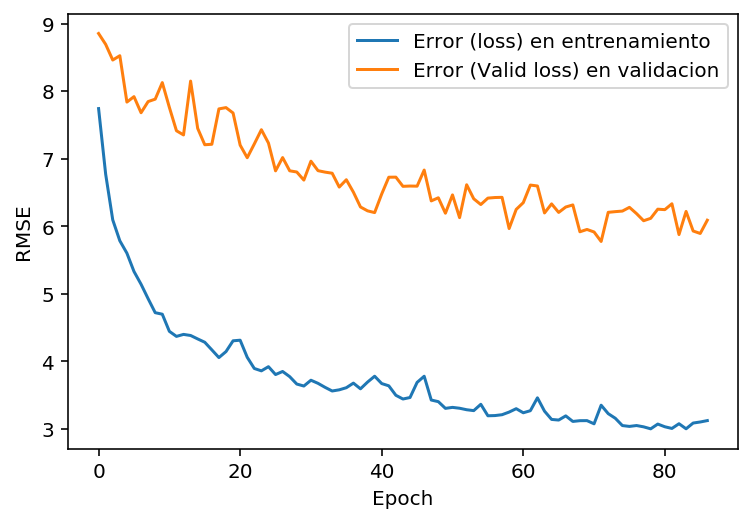

In [0]:
# Se crean las opciones de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15)
model_check = ModelCheckpoint('best_model_finetuning.h5', monitor='val_loss', mode='min', save_best_only=True)
callbacks_list = [early_stopping, model_check]

t = timing()
history_modelV5 = model_customV5.fit_generator(
                                      train_generator,
                                      epochs=100,  # numero de epochs
                                      verbose=2,  # muestra informacion del error al finalizar cada epoch
                                      steps_per_epoch=len(train_data)/batch_size,
                                      validation_data=val_generator,
                                      validation_steps=len(val_data)/batch_size,
                                      callbacks=callbacks_list)
t("Training time for Custom Model V5")


# Se carga el mejor modelo obtenido con el proceso de EarlyStopping dado que el valor del parametro patiente es 3 
saved_model = load_model('best_model_finetuning.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# Por ultimo, podemos evaluar el modelo en el conjunto de test
print()
test_loss_v5, test_acc_v5 = model_customV5.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_acc: %.4f" % (test_loss_v5, test_acc_v5))  


plot_history(history_modelV5)